# Binary classification of lowcov and highcov aDNA samples ($n=10+15$)

Train the classifiers separately, using specific related columns (e.g., Alu classifier does not use L1 or SVA related columns) at FP sites and TP sites (e.g., Alu classifier uses Alu TP sites, not L1 or SVA TP sites) **instead of** train a four-class classifier.

In [1]:
# libraries for preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

# libraries for model training and evaluation
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from time import time
# from scipy.stats import ttest_ind # t test
from scipy.stats import wilcoxon
from sklearn.inspection import permutation_importance # for feature importance

## Summary of training and testing data

### Summary of TP/FP counts in training data (chr1 + unmapped)
| Types      | Counts (passing xTea-ML filters%) | Raw Counts |
| ----------- | ----------- | ----------- |
| Total      | 22540       | 24850 |
| TP (Alu/L1/SVA)   |  10041     | 12350 |
| TP - Alu       |  2410 (86.1%)    | 2800 |
| TP - L1       |  6969 (79.6%)  |  8750  |
| TP - SVA     |  662 (82.8%)    |  800    |
| FP        | 12500    |  12500  |

**80\% is used for model training (pick hyperparameters with 5-fold CV), 20\% is used for testing**

### Summary of TP/FP counts in testing data (chr2 + unmapped)
| Types      | Counts (passing xTea-ML filters%) | Raw Counts |
| ----------- | ----------- | ----------- |
| Total      |  24516      |  27100  |
| TP (Alu/L1/SVA)   |  12016   | 14600 |
| TP - Alu       |  2728 (88.7%)   |  3075  |
| TP - L1       |  8743 (80.4%)   |  10875  |
| TP - SVA     |  545 (83.8%)    |  650  |
| FP        | 12500    |  12500  |

### Summary of number of features
| Types      | Counts |
| ------------ | ------ |
| Raw       | 20    |
| After preprocessing | 15   |

## Functions for data cleaning

In [2]:
def drop_features(input_file):
    df = pd.read_csv(input_file, sep="\t")
    df.rename(columns={"15": "TE_start"}, inplace=True)
    
    df['TE_ins'] = np.where(df['TE_family']!= '.', 1, 0)
    df = df.drop(["#chr", "pos", "TE_chr", "TE_start", "TE_family", "TE_length"], axis=1)

    return df


def feature_normalization(df, RT):
    features_norm = df.drop(['lclip', 'rclip', f"cr_{RT}", f"cns_{RT}", 'raw_ldisc', 'raw_rdisc', f"ldisc_{RT}", f"rdisc_{RT}", f"dr_{RT}", 
                         'l_cov', 'r_cov', 'polyA', 'cns_std_l_polyA', 'cns_std_r_polyA'], axis=1)
    labels = df['TE_ins']
    features_norm['lclip'] = np.where(df['l_cov']>0, df['lclip']/df['l_cov'], 0)
    features_norm['rclip'] = np.where(df['r_cov']>0, df['rclip']/df['r_cov'], 0)
    features_norm[f"cr_{RT}"] = np.where(df['lclip']+df['rclip']>0, df[f"cr_{RT}"]/(df['lclip']+df['rclip']), 0)
    features_norm[f"cns_{RT}"] = np.where(df['lclip']+df['rclip']>0, df[f"cns_{RT}"]/(df['lclip']+df['rclip']), 0)
    features_norm[f"ldisc_{RT}"] = np.where(df['r_cov']>0, df[f"ldisc_{RT}"]/df['r_cov'], 0)
    features_norm[f"rdisc_{RT}"] = np.where(df['l_cov']>0, df[f"rdisc_{RT}"]/df['l_cov'], 0)
    features_norm[f"dr_{RT}"] = np.where(df['raw_ldisc']+df['raw_rdisc']>0, df[f"dr_{RT}"]/(df['raw_ldisc']+df['raw_rdisc']), 0)
    features_norm['cns_std_l_polyA'] = np.where(df['l_cov']>0, df['cns_std_l_polyA']/df['l_cov'], 0)
    features_norm['cns_std_r_polyA'] = np.where(df['r_cov']>0, df['cns_std_r_polyA']/df['r_cov'], 0)
    
    features_norm.to_csv(f"./data/{RT}_cleaned.tsv", index=False, sep='\t', header=True)
    features = features_norm.drop('TE_ins', axis=1)
    
    return features, labels


def split_data(features, labels, RT, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, shuffle=True)
    X_train.to_csv(f"./data/{RT}_train_features.csv", index=False)
    X_test.to_csv(f"./data/{RT}_test_features.csv", index=False)
    y_train.to_csv(f"./data/{RT}_train_labels.csv", index=False)
    y_test.to_csv(f"./data/{RT}_test_labels.csv", index=False)
    
    return X_train, X_test, y_train, y_test


def data_cleaning(input_file, RT):
    df = drop_features(input_file)
    features, labels = feature_normalization(df, RT)
    X_train, X_test, y_train, y_test = split_data(features, labels, RT)
    
    return X_train, X_test, y_train, y_test

## Functions for model training

In [3]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

def LR_training(tr_features, tr_labels, RT):
    lr = LogisticRegression(max_iter=500)
    parameters = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000, 10000]
    }

    cv = GridSearchCV(lr, parameters, cv=5, scoring='balanced_accuracy')
    cv.fit(tr_features, tr_labels.values.ravel()) #.values.ravel() converts a pandas series into an array

    print_results(cv)
    joblib.dump(cv.best_estimator_, f"./models/{RT}_LR_model.pkl")

def MLP_training(tr_features, tr_labels, RT):
    mlp = MLPClassifier(max_iter=500)
    parameters = {
        'hidden_layer_sizes': [(10,), (50,), (100,)],
        'activation': ['relu', 'tanh', 'logistic'],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
    }

    cv = GridSearchCV(mlp, parameters, cv=5, scoring='balanced_accuracy')
    cv.fit(tr_features, tr_labels.values.ravel())

    print_results(cv)
    joblib.dump(cv.best_estimator_, f"./models/{RT}_MLP_model.pkl")

def RF_training(tr_features, tr_labels, RT):
    rf = RandomForestClassifier()
    parameters = {
        'n_estimators': [5, 50, 250],
        'max_depth': [2, 4, 8, 16, 32, None]
    }

    cv = GridSearchCV(rf, parameters, cv=5, scoring='balanced_accuracy')
    cv.fit(tr_features, tr_labels.values.ravel())

    print_results(cv)
    joblib.dump(cv.best_estimator_, f"./models/{RT}_RF_model.pkl")

def GB_training(tr_features, tr_labels, RT):
    gb = GradientBoostingClassifier()
    parameters = {
        'n_estimators': [5, 50, 250, 500],
        'max_depth': [1, 3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 1, 10, 100]
    }

    cv = GridSearchCV(gb, parameters, cv=5, scoring='balanced_accuracy')
    cv.fit(tr_features, tr_labels.values.ravel())

    print_results(cv)
    joblib.dump(cv.best_estimator_, f"./models/{RT}_GB_model.pkl")

## Functions for model evaluation

In [4]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    bal_accuracy = round(balanced_accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    mat = confusion_matrix(labels, pred)
    print('{} -- Balanced Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   bal_accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))
    print("Confusion matrix:")
    print(mat)
    print("-------------------------------------------------------------------------------------------")

def evaluate_model_main(RT, X_test, y_test):
    models = {}

    for mdl in ['LR', 'MLP', 'RF', 'GB']:
        models[mdl] = joblib.load(f'./models/{RT}_{mdl}_model.pkl')
    print(models)
    for name, mdl in models.items():
        evaluate_model(name, mdl, X_test, y_test)

## Train binary classification models for Alu, L1, SVA, respectively

In [7]:
X_Alu_train, X_Alu_test, y_Alu_train, y_Alu_test = data_cleaning("./data/Alu.impute.out", "Alu")
LR_training(X_Alu_train, y_Alu_train, "Alu")
MLP_training(X_Alu_train, y_Alu_train, "Alu")
RF_training(X_Alu_train, y_Alu_train, "Alu")
GB_training(X_Alu_train, y_Alu_train, "Alu")

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

BEST PARAMS: {'C': 500}

0.547 (+/-0.014) for {'C': 0.001}
0.624 (+/-0.024) for {'C': 0.01}
0.661 (+/-0.027) for {'C': 0.1}
0.671 (+/-0.024) for {'C': 1}
0.675 (+/-0.019) for {'C': 10}
0.678 (+/-0.021) for {'C': 100}
0.679 (+/-0.023) for {'C': 500}
0.677 (+/-0.021) for {'C': 1000}
0.677 (+/-0.018) for {'C': 5000}
0.678 (+/-0.018) for {'C': 10000}


c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


BEST PARAMS: {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}

0.929 (+/-0.019) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.93 (+/-0.024) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.929 (+/-0.013) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.935 (+/-0.025) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.937 (+/-0.019) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.937 (+/-0.024) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.943 (+/-0.011) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.941 (+/-0.024) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.944 (+/-0.016) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'lea

In [8]:
X_L1_train, X_L1_test, y_L1_train, y_L1_test = data_cleaning("./data/L1.impute.out", "L1")
LR_training(X_L1_train, y_L1_train, "L1")
MLP_training(X_L1_train, y_L1_train, "L1")
RF_training(X_L1_train, y_L1_train, "L1")
GB_training(X_L1_train, y_L1_train, "L1")

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

BEST PARAMS: {'C': 10000}

0.726 (+/-0.01) for {'C': 0.001}
0.78 (+/-0.018) for {'C': 0.01}
0.793 (+/-0.013) for {'C': 0.1}
0.797 (+/-0.01) for {'C': 1}
0.798 (+/-0.01) for {'C': 10}
0.798 (+/-0.009) for {'C': 100}
0.798 (+/-0.009) for {'C': 500}
0.798 (+/-0.011) for {'C': 1000}
0.798 (+/-0.007) for {'C': 5000}
0.799 (+/-0.011) for {'C': 10000}


c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


BEST PARAMS: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

0.941 (+/-0.01) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.937 (+/-0.013) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.939 (+/-0.013) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.944 (+/-0.007) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.943 (+/-0.008) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.939 (+/-0.016) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.946 (+/-0.005) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.942 (+/-0.003) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.944 (+/-0.006) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learnin

In [5]:
X_SVA_train, X_SVA_test, y_SVA_train, y_SVA_test = data_cleaning("./data/SVA.impute.out", "SVA")
LR_training(X_SVA_train, y_SVA_train, "SVA")
MLP_training(X_SVA_train, y_SVA_train, "SVA")
RF_training(X_SVA_train, y_SVA_train, "SVA")
GB_training(X_SVA_train, y_SVA_train, "SVA")

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


BEST PARAMS: {'C': 10000}

0.503 (+/-0.007) for {'C': 0.001}
0.513 (+/-0.024) for {'C': 0.01}
0.53 (+/-0.025) for {'C': 0.1}
0.539 (+/-0.032) for {'C': 1}
0.547 (+/-0.029) for {'C': 10}
0.549 (+/-0.026) for {'C': 100}
0.551 (+/-0.028) for {'C': 500}
0.551 (+/-0.029) for {'C': 1000}
0.552 (+/-0.028) for {'C': 5000}
0.554 (+/-0.028) for {'C': 10000}
BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

0.877 (+/-0.037) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.877 (+/-0.016) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.86 (+/-0.082) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.882 (+/-0.066) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.879 (+/-0.06) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.899 (+/-0.041) for {'activation': 'relu'

In [6]:
RT_list = ["Alu", "L1", "SVA"]
for rt in RT_list:
    X_test = pd.read_csv(f'./data/{rt}_test_features.csv')
    y_test = pd.read_csv(f'./data/{rt}_test_labels.csv')

    evaluate_model_main(rt, X_test, y_test)
    print("===========================================================================================================\n")

{'LR': LogisticRegression(C=500, max_iter=500), 'MLP': MLPClassifier(activation='logistic', hidden_layer_sizes=(50,),
              learning_rate='adaptive', max_iter=500), 'RF': RandomForestClassifier(max_depth=32, n_estimators=250), 'GB': GradientBoostingClassifier(n_estimators=500)}
LR -- Balanced Accuracy: 0.685 / Precision: 0.743 / Recall: 0.397 / Latency: 10.0ms
Confusion matrix:
[[2443   65]
 [ 286  188]]
-------------------------------------------------------------------------------------------
MLP -- Balanced Accuracy: 0.948 / Precision: 0.915 / Recall: 0.911 / Latency: 7.0ms
Confusion matrix:
[[2468   40]
 [  42  432]]
-------------------------------------------------------------------------------------------
RF -- Balanced Accuracy: 0.959 / Precision: 0.94 / Recall: 0.928 / Latency: 93.0ms
Confusion matrix:
[[2480   28]
 [  34  440]]
-------------------------------------------------------------------------------------------
GB -- Balanced Accuracy: 0.963 / Precision: 0.951 /

## Training results (on held out data, chr1 + unmapped)

| TE family  |  Best model |   Balanced Accuracy  |  Precision (chr1 only) |  Recall (uncorrected) | Recall (corrected) | Latency (ms) |
| ----------- | ----------- | -------------------- | ---------------------- | ------------------- | -------------------- | ------------ |
| Alu      |  GB       |  0.963           |   0.951          |  0.935          |    0.791        | 16.0      |
| L1       |  RF       |  0.962          |   0.949          |  0.953          |     0.766      |  132.0      |
| SVA      |  MLP   |    0.911            |     0.885         |   0.827         |      0.719      | 5.0     |

## Functions for cleaning test data (chr2 + unmapped)

In [21]:
def label_family(df, RT):
    df = df.replace({'TE_family': '.'}, {'TE_family': 0}, regex=False)
    if RT == "Alu":
        df = df.replace(regex=r'^SINE/Alu.*$', value=1)
        df = df.replace(regex=r'^LINE/L1.*$', value=0)
        df = df.replace(regex=r'^Retroposon/SVA.*$', value=0)
    elif RT == "L1":
        df = df.replace(regex=r'^SINE/Alu.*$', value=0)
        df = df.replace(regex=r'^LINE/L1.*$', value=1)
        df = df.replace(regex=r'^Retroposon/SVA.*$', value=0)
    else:
        df = df.replace(regex=r'^SINE/Alu.*$', value=0)
        df = df.replace(regex=r'^LINE/L1.*$', value=0)
        df = df.replace(regex=r'^Retroposon/SVA.*$', value=1)
    return df

def test_feature_normalization(df, RT, sample, in_dir):
    features_norm = df.drop(['lclip', 'rclip', "cr", "cns", 'raw_ldisc', 'raw_rdisc', "ldisc", "rdisc", "dr", 
                             'l_cov', 'r_cov', 'polyA', 'cns_std_l_polyA', 'cns_std_r_polyA'], axis=1)
    labels = df['TE_family']
    features_norm['lclip'] = np.where(df['l_cov']>0, df['lclip']/df['l_cov'], 0)
    features_norm['rclip'] = np.where(df['r_cov']>0, df['rclip']/df['r_cov'], 0)
    features_norm["cr"] = np.where(df['lclip']+df['rclip']>0, df["cr"]/(df['lclip']+df['rclip']), 0)
    features_norm["cns"] = np.where(df['lclip']+df['rclip']>0, df["cns"]/(df['lclip']+df['rclip']), 0)
    features_norm["ldisc"] = np.where(df['r_cov']>0, df["ldisc"]/df['r_cov'], 0)
    features_norm["rdisc"] = np.where(df['l_cov']>0, df["rdisc"]/df['l_cov'], 0)
    features_norm["dr"] = np.where(df['raw_ldisc']+df['raw_rdisc']>0, df["dr"]/(df['raw_ldisc']+df['raw_rdisc']), 0)
    features_norm['cns_std_l_polyA'] = np.where(df['l_cov']>0, df['cns_std_l_polyA']/df['l_cov'], 0)
    features_norm['cns_std_r_polyA'] = np.where(df['r_cov']>0, df['cns_std_r_polyA']/df['r_cov'], 0)
    
    features_norm.to_csv(f"{in_dir}{sample}.{RT}.cleaned.tsv", index=False, sep='\t', header=True)
    features = features_norm.drop('TE_family', axis=1)
    
    return features, labels

def test_data_calculation(RT, sample, in_dir='./data/final_test_data_by_RT/'):
    input_file = in_dir + sample + "." + RT + ".out"
    df = pd.read_csv(input_file, sep="\t")
    df.columns = ["chr", "pos", "TE_chr", "TE_start", "TE_end", "TE_family", "TE_length",
                  "nearby_sites",
                  "lclip", "rclip",
                  "cr", "cns",
                  "raw_ldisc", "raw_rdisc", "ldisc", "rdisc",
                  "ratio_lcluster", "ratio_rcluster",
                  "dr",
                  "longest_clip_len", "l_cov", "r_cov", "polyA", "cns_std_l_polyA", "cns_std_r_polyA", "ratio_low_MAPQ", "clip_pos_std"]
    df = label_family(df, RT)
    df = df.drop(["chr", "pos", "TE_chr", "TE_start", "TE_end", "TE_length"], axis=1)
    features, labels = test_feature_normalization(df, RT, sample, in_dir)
    
    if RT == "Alu":
        mdl = 'GB'
    elif RT == "SVA":
        mdl = 'MLP'
    else:
        mdl = 'RF'
    model = joblib.load(f'./models/{RT}_{mdl}_model.pkl')
    evaluate_model(mdl, model, features, labels)

In [22]:
RT_list = ["Alu", "L1", "SVA"]
sample_list = ["I7224", "I1581", "I4233", "I4562", "I5109", "I5698", "I2170", "I6730", "I7491", "I0231", "I1633", "I5233",
               "I2514", "I5742", "I2935", "I5725", "I4877", "I2862", "I1734", "I3133", "I4432", "I2861", "I5838", "I3957", "I3255"]

for rt in RT_list:
    for sample in sample_list:
        print(f"{rt}: {sample}")
        test_data_calculation(rt, sample)

Alu: I7224
GB -- Balanced Accuracy: 0.788 / Precision: 0.195 / Recall: 0.891 / Latency: 9.0ms
Confusion matrix:
[[512 235]
 [  7  57]]
-------------------------------------------------------------------------------------------
Alu: I1581
GB -- Balanced Accuracy: 0.787 / Precision: 0.227 / Recall: 0.833 / Latency: 6.0ms
Confusion matrix:
[[486 170]
 [ 10  50]]
-------------------------------------------------------------------------------------------
Alu: I4233
GB -- Balanced Accuracy: 0.785 / Precision: 0.258 / Recall: 0.906 / Latency: 7.0ms
Confusion matrix:
[[545 276]
 [ 10  96]]
-------------------------------------------------------------------------------------------
Alu: I4562
GB -- Balanced Accuracy: 0.769 / Precision: 0.227 / Recall: 0.866 / Latency: 7.0ms
Confusion matrix:
[[495 242]
 [ 11  71]]
-------------------------------------------------------------------------------------------
Alu: I5109
GB -- Balanced Accuracy: 0.78 / Precision: 0.242 / Recall: 0.857 / Latency: 7.0ms

RF -- Balanced Accuracy: 0.857 / Precision: 0.69 / Recall: 0.952 / Latency: 66.0ms
Confusion matrix:
[[485 152]
 [ 17 339]]
-------------------------------------------------------------------------------------------
L1: I5742
RF -- Balanced Accuracy: 0.875 / Precision: 0.726 / Recall: 0.985 / Latency: 66.5ms
Confusion matrix:
[[493 151]
 [  6 400]]
-------------------------------------------------------------------------------------------
L1: I2935
RF -- Balanced Accuracy: 0.879 / Precision: 0.742 / Recall: 0.979 / Latency: 59.0ms
Confusion matrix:
[[503 143]
 [  9 411]]
-------------------------------------------------------------------------------------------
L1: I5725
RF -- Balanced Accuracy: 0.869 / Precision: 0.723 / Recall: 0.983 / Latency: 63.0ms
Confusion matrix:
[[487 159]
 [  7 415]]
-------------------------------------------------------------------------------------------
L1: I4877
RF -- Balanced Accuracy: 0.865 / Precision: 0.727 / Recall: 0.969 / Latency: 73.0ms
Confusion

## Result (corrected precision/recall)

In [24]:
def evaluate_model_corrected(model, features, labels, sample, RT, bal_accuracy_list, precision_list, recall_list, f1_score_list):
    pred = model.predict(features)
    bal_accuracy = round(balanced_accuracy_score(labels, pred), 3)
    mat = confusion_matrix(labels, pred)
    if RT == "Alu":
        total_TE = 123
        FP_total = 961
    elif RT == "L1":
        total_TE = 435
        FP_total = 649
    else:
        total_TE = 26
        FP_total = 1058
    FP = mat[0,1]
    TP = mat[1,1]
    precision = np.round(TP/(TP + FP), 3)
    recall = np.round(TP/total_TE, 3)
    FP_recall = np.round(mat[0,0]/FP_total, 3)
    bal_accuracy = np.round((recall + FP_recall)/2, 3)
    f1_score = np.round(2 * precision * recall/(precision+recall), 3)
    bal_accuracy_list.append(bal_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)

def postprocess_stats(sample_list, RT, bal_accuracy_list, precision_list, recall_list, f1_score_list):
    bal_accuracy = np.array(bal_accuracy_list)
    precision = np.array(precision_list)
    recall = np.array(recall_list)
    f1_score = np.array(f1_score_list)
    df = pd.DataFrame({'Corr Balanced Acc': bal_accuracy, 'Precision':precision, 'Corr Recall': recall, 'Corr F1-score': f1_score}, index=sample_list)
    print(RT)
    print(df)
    
    return df

def calc_stats_main(sample_list, RT, in_dir='./data/final_test_data_by_RT/'):
    if RT == "Alu":
        mdl = 'GB'
    elif RT == "SVA":
        mdl = 'MLP'
    else:
        mdl = 'RF'
    model = joblib.load(f'./models/{RT}_{mdl}_model.pkl')
    
    bal_accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    for sample in sample_list:
        input_file = in_dir + sample + "." + RT + ".out"
        df = pd.read_csv(input_file, sep="\t")
        df.columns = ["chr", "pos", "TE_chr", "TE_start", "TE_end", "TE_family", "TE_length",
                      "nearby_sites",
                      "lclip", "rclip",
                      "cr", "cns",
                      "raw_ldisc", "raw_rdisc", "ldisc", "rdisc",
                      "ratio_lcluster", "ratio_rcluster",
                      "dr",
                      "longest_clip_len", "l_cov", "r_cov", "polyA", "cns_std_l_polyA", "cns_std_r_polyA", "ratio_low_MAPQ", "clip_pos_std"]
        df = label_family(df, RT)
        df = df.drop(["chr", "pos", "TE_chr", "TE_start", "TE_end", "TE_length"], axis=1)
        features, labels = test_feature_normalization(df, RT, sample, in_dir)
        evaluate_model_corrected(model, features, labels, sample, RT, bal_accuracy_list, precision_list, recall_list, f1_score_list)
    
    df = postprocess_stats(sample_list, RT, bal_accuracy_list, precision_list, recall_list, f1_score_list)
    
    return df

In [25]:
RT_list = ["Alu", "L1", "SVA"]
lowcov_sample_list = ["I7224", "I1581", "I4233", "I4562", "I5109", "I5698", "I2170", "I6730", "I7491", "I0231"]
highcov_sample_list = ["I1633", "I5233", "I2514", "I5742", "I2935", "I5725", "I4877", "I2862", "I1734", "I3133", 
                       "I4432", "I2861", "I5838", "I3957", "I3255"]

for rt in RT_list:
    if rt == "Alu":
        Alu_lowcov_df = calc_stats_main(lowcov_sample_list, rt)
        Alu_lowcov_df.to_csv(f"./stats/binary/{rt}_lowcov.tsv", index=True, sep='\t', header=True)
    elif rt == "L1":
        L1_lowcov_df = calc_stats_main(lowcov_sample_list, rt)
        L1_lowcov_df.to_csv(f"./stats/binary/{rt}_lowcov.tsv", index=True, sep='\t', header=True)
    else:
        SVA_lowcov_df = calc_stats_main(lowcov_sample_list, rt)
        SVA_lowcov_df.to_csv(f"./stats/binary/{rt}_lowcov.tsv", index=True, sep='\t', header=True)
    print("--------------------------------------------------------------------")
    if rt == "Alu":
        Alu_highcov_df = calc_stats_main(highcov_sample_list, rt)
        Alu_highcov_df.to_csv(f"./stats/binary/{rt}_highcov.tsv", index=True, sep='\t', header=True)
    elif rt == "L1":
        L1_highcov_df = calc_stats_main(highcov_sample_list, rt)
        L1_highcov_df.to_csv(f"./stats/binary/{rt}_highcov.tsv", index=True, sep='\t', header=True)
    else:
        SVA_highcov_df = calc_stats_main(highcov_sample_list, rt)
        SVA_highcov_df.to_csv(f"./stats/binary/{rt}_highcov.tsv", index=True, sep='\t', header=True)
    print("====================================================================")

Alu
       Corr Balanced Acc  Precision  Corr Recall  Corr F1-score
I7224              0.498      0.195        0.463          0.274
I1581              0.456      0.227        0.407          0.291
I4233              0.674      0.258        0.780          0.388
I4562              0.546      0.227        0.577          0.326
I5109              0.569      0.242        0.585          0.342
I5698              0.651      0.249        0.724          0.371
I2170              0.691      0.279        0.813          0.415
I6730              0.698      0.267        0.813          0.402
I7491              0.683      0.244        0.780          0.372
I0231              0.599      0.240        0.691          0.356
--------------------------------------------------------------------
Alu
       Corr Balanced Acc  Precision  Corr Recall  Corr F1-score
I1633              0.756      0.240        0.911          0.380
I5233              0.768      0.229        0.967          0.370
I2514              0.736   

# Compare binary vs multi- classifiers

Load multi-classifier stats

In [8]:
multi_dir = './stats/multi/'
multi_Alu_low = pd.read_csv(multi_dir + "Alu_lowcov.tsv", index_col=0, sep="\t")
multi_L1_low = pd.read_csv(multi_dir + "L1_lowcov.tsv", index_col=0, sep="\t")
multi_SVA_low = pd.read_csv(multi_dir + "SVA_lowcov.tsv", index_col=0, sep="\t")
multi_Alu_high = pd.read_csv(multi_dir + "Alu_highcov.tsv", index_col=0, sep="\t")
multi_L1_high = pd.read_csv(multi_dir + "L1_highcov.tsv", index_col=0, sep="\t")
multi_SVA_high = pd.read_csv(multi_dir + "SVA_highcov.tsv", index_col=0, sep="\t")
RT_list = ["Alu", "L1", "SVA"]
multi_Alu_low.head()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
I7224,0.443,0.302,0.154,0.204
I1581,0.380,0.263,0.122,0.167
I4233,0.598,0.516,0.390,0.444
I4562,0.504,0.507,0.276,0.357
I5109,0.503,0.451,0.260,0.330


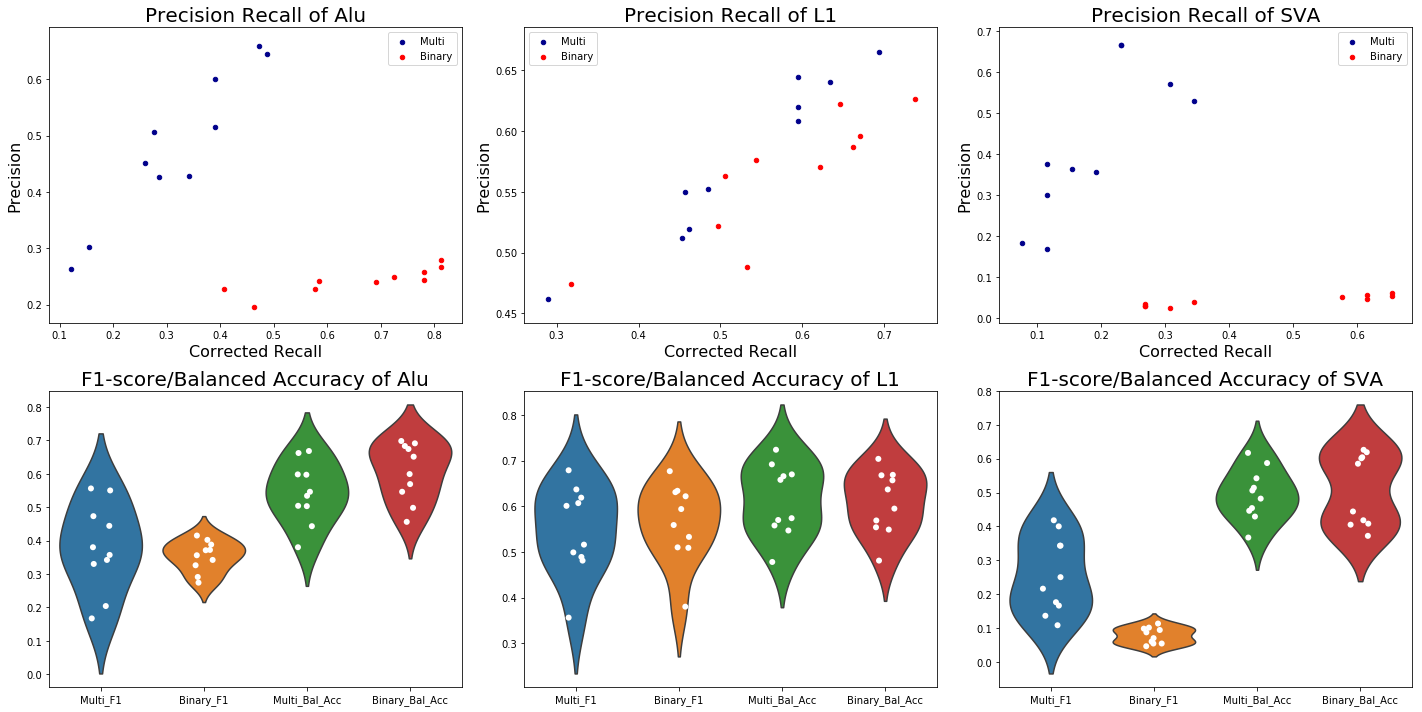

In [26]:
fig, axes = plt.subplots(2, len(RT_list), figsize=(20, 10))
for i in range(len(RT_list)):
    if RT_list[i] == "Alu":
        multi_Alu_low.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi", ax=axes[0,i])
        Alu_lowcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Red", label="Binary", ax=axes[0,i])
        new = pd.DataFrame({"Multi_F1":list(multi_Alu_low["Corr F1-score"]), "Binary_F1":list(Alu_lowcov_df["Corr F1-score"]),
                           "Multi_Bal_Acc":list(multi_Alu_low["Corr Balanced Accu"]), "Binary_Bal_Acc":list(Alu_lowcov_df["Corr Balanced Acc"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    elif RT_list[i] == "L1":
        multi_L1_low.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi", ax=axes[0,i])
        L1_lowcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Red", label="Binary", ax=axes[0,i])
        new = pd.DataFrame({"Multi_F1":list(multi_L1_low["Corr F1-score"]), "Binary_F1":list(L1_lowcov_df["Corr F1-score"]),
                           "Multi_Bal_Acc":list(multi_L1_low["Corr Balanced Accu"]), "Binary_Bal_Acc":list(L1_lowcov_df["Corr Balanced Acc"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    else:
        multi_SVA_low.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi", ax=axes[0,i])
        SVA_lowcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Red", label="Binary", ax=axes[0,i])
        new = pd.DataFrame({"Multi_F1":list(multi_SVA_low["Corr F1-score"]), "Binary_F1":list(SVA_lowcov_df["Corr F1-score"]),
                           "Multi_Bal_Acc":list(multi_SVA_low["Corr Balanced Accu"]), "Binary_Bal_Acc":list(SVA_lowcov_df["Corr Balanced Acc"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    
    axes[0, i].set_title(f"Precision Recall of {RT_list[i]}", fontsize = 20)
    axes[0, i].set_xlabel("Corrected Recall", fontsize=16)
    axes[0, i].set_ylabel("Precision", fontsize=16)
    axes[1, i].set_title(f"F1-score/Balanced Accuracy of {RT_list[i]}", fontsize=20)
    
plt.tight_layout()
plt.savefig("./stats/lowcov_Multi_vs_Binary.png")

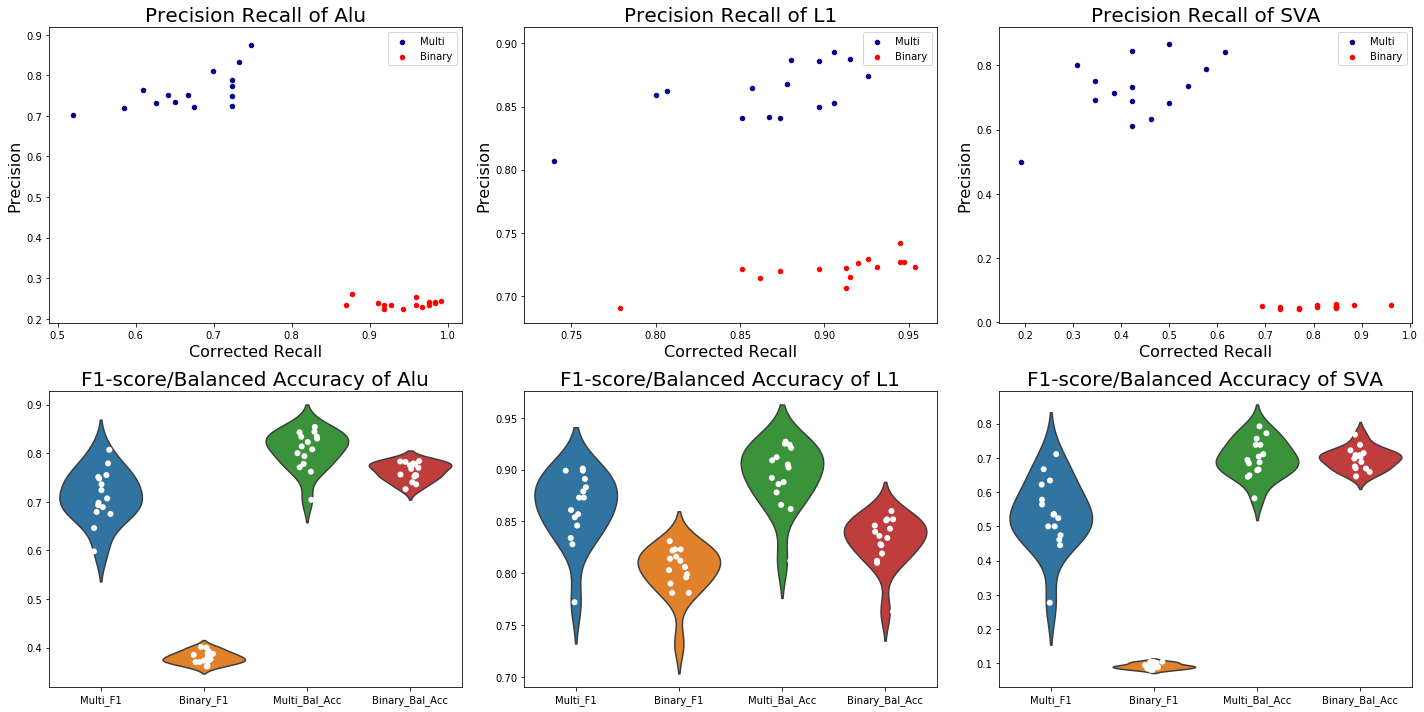

In [27]:
fig, axes = plt.subplots(2, len(RT_list), figsize=(20, 10))
for i in range(len(RT_list)):
    if RT_list[i] == "Alu":
        multi_Alu_high.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi", ax=axes[0,i])
        Alu_highcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Red", label="Binary", ax=axes[0,i])
        new = pd.DataFrame({"Multi_F1":list(multi_Alu_high["Corr F1-score"]), "Binary_F1":list(Alu_highcov_df["Corr F1-score"]),
                           "Multi_Bal_Acc":list(multi_Alu_high["Corr Balanced Accu"]), "Binary_Bal_Acc":list(Alu_highcov_df["Corr Balanced Acc"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    elif RT_list[i] == "L1":
        multi_L1_high.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi", ax=axes[0,i])
        L1_highcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Red", label="Binary", ax=axes[0,i])
        new = pd.DataFrame({"Multi_F1":list(multi_L1_high["Corr F1-score"]), "Binary_F1":list(L1_highcov_df["Corr F1-score"]),
                           "Multi_Bal_Acc":list(multi_L1_high["Corr Balanced Accu"]), "Binary_Bal_Acc":list(L1_highcov_df["Corr Balanced Acc"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    else:
        multi_SVA_high.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi", ax=axes[0,i])
        SVA_highcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Red", label="Binary", ax=axes[0,i])
        new = pd.DataFrame({"Multi_F1":list(multi_SVA_high["Corr F1-score"]), "Binary_F1":list(SVA_highcov_df["Corr F1-score"]),
                           "Multi_Bal_Acc":list(multi_SVA_high["Corr Balanced Accu"]), "Binary_Bal_Acc":list(SVA_highcov_df["Corr Balanced Acc"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    
    axes[0, i].set_title(f"Precision Recall of {RT_list[i]}", fontsize = 20)
    axes[0, i].set_xlabel("Corrected Recall", fontsize=16)
    axes[0, i].set_ylabel("Precision", fontsize=16)
    axes[1, i].set_title(f"F1-score/Balanced Accuracy of {RT_list[i]}", fontsize=20)
    
plt.tight_layout()
plt.savefig("./stats/highcov_Multi_vs_Binary.png")

# Compare xTea-ML binary/xTea-ML multi vs MELT vs xTea

In [9]:
xTea_low = pd.read_csv("./stats/xTEA_lowcov.tsv", sep="\t")
xTea_high = pd.read_csv("./stats/xTEA_highcov.tsv", sep="\t")
MELT_low = pd.read_csv("./stats/MELT_lowcov.tsv", sep="\t")
MELT_high = pd.read_csv("./stats/MELT_highcov.tsv", sep="\t")
xTea_low.head()

,sample,Alu_pre,L1_pre,SVA_pre,Alu_sen,L1_sen,SVA_sen,Alu_F1,L1_F1,SVA_F1
0,I7224,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,I1581,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,I4233,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,I4562,0.0,0.5,0,0.0,0.002299,0.0,0.0,0.004577,0.0
4,I5109,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.000000,0.0


Alu
multi: 0.36850000000000005, binary: 0.3635, xTea:0.0, MELT:0.0, wilcoxon test p-value: 0.3862707203664827, avg latency:9.3 ms
L1
multi: 0.5585, binary: 0.5765, xTea:0.0022883295194508005, MELT:0.0, wilcoxon test p-value: 0.028314054945765665, avg latency:54.4 ms
SVA
multi: 0.233, binary: 0.0785, xTea:0.0, MELT:0.0, wilcoxon test p-value: 0.005062032126267864, avg latency:3.87 ms


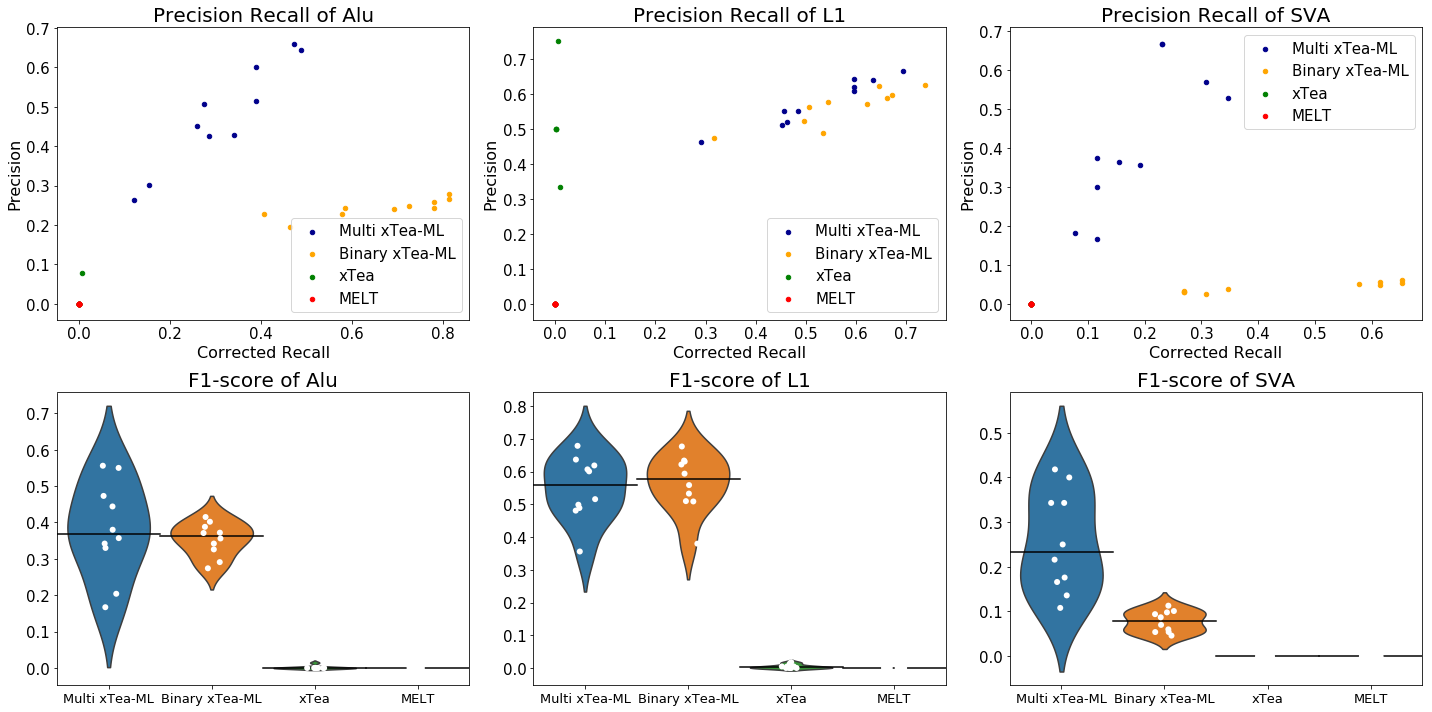

In [30]:
fig, axes = plt.subplots(2, len(RT_list), figsize=(20, 10))
for i in range(len(RT_list)):
    if RT_list[i] == "Alu":
        multi_Alu_low.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi xTea-ML", ax=axes[0,i])
        Alu_lowcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Orange", label="Binary xTea-ML", ax=axes[0,i])
        xTea_low.plot.scatter(y="Alu_pre", x="Alu_sen", c="Green", label="xTea", ax=axes[0,i])
        MELT_low.plot.scatter(y="Alu_pre", x="Alu_sen", c="Red", label="MELT", ax=axes[0,i])
        axes[0,i].legend(prop={'size':15})
        axes[0,i].tick_params(axis='x', labelsize=15)
        axes[0,i].tick_params(axis='y', labelsize=15)
        multi_median = np.median(multi_Alu_low["Corr F1-score"])
        bi_median = np.median(Alu_lowcov_df["Corr F1-score"])
        xTea_median = np.median(xTea_low["Alu_F1"])
        melt_median = np.median(MELT_low["Alu_F1"])
        _, p_val = wilcoxon(multi_Alu_low["Corr F1-score"], Alu_lowcov_df["Corr F1-score"])
        print("Alu")
        print(f"multi: {multi_median}, binary: {bi_median}, xTea:{xTea_median}, MELT:{melt_median}, "
              f"wilcoxon test p-value: {p_val}, avg latency:9.3 ms")
        axes[1, i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.25)
        axes[1, i].axhline(y = bi_median, color="black", xmin = 0.25, xmax = 0.5)
        axes[1, i].axhline(y = xTea_median, color="black", xmin = 0.5, xmax = 0.75)
        axes[1, i].axhline(y = melt_median, color="black", xmin = 0.75, xmax = 1)
        axes[1,i].tick_params(axis='x', labelsize=13)
        axes[1,i].tick_params(axis='y', labelsize=15)
        new = pd.DataFrame({"Multi xTea-ML":list(multi_Alu_low["Corr F1-score"]), "Binary xTea-ML":list(Alu_lowcov_df["Corr F1-score"]),
                           "xTea":list(xTea_low["Alu_F1"]), "MELT":list(MELT_low["Alu_F1"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    elif RT_list[i] == "L1":
        multi_L1_low.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi xTea-ML", ax=axes[0,i])
        L1_lowcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Orange", label="Binary xTea-ML", ax=axes[0,i])
        xTea_low.plot.scatter(y="L1_pre", x="L1_sen", c="Green", label="xTea", ax=axes[0,i])
        MELT_low.plot.scatter(y="L1_pre", x="L1_sen", c="Red", label="MELT", ax=axes[0,i])
        axes[0,i].legend(prop={'size':15})
        axes[0,i].tick_params(axis='x', labelsize=15)
        axes[0,i].tick_params(axis='y', labelsize=15)
        multi_median = np.median(multi_L1_low["Corr F1-score"])
        bi_median = np.median(L1_lowcov_df["Corr F1-score"])
        xTea_median = np.median(xTea_low["L1_F1"])
        melt_median = np.median(MELT_low["L1_F1"])
        _, p_val = wilcoxon(multi_L1_low["Corr F1-score"], L1_lowcov_df["Corr F1-score"])
        print("L1")
        print(f"multi: {multi_median}, binary: {bi_median}, xTea:{xTea_median}, MELT:{melt_median}, "
              f"wilcoxon test p-value: {p_val}, avg latency:54.4 ms")
        axes[1, i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.25)
        axes[1, i].axhline(y = bi_median, color="black", xmin = 0.25, xmax = 0.5)
        axes[1, i].axhline(y = xTea_median, color="black", xmin = 0.5, xmax = 0.75)
        axes[1, i].axhline(y = melt_median, color="black", xmin = 0.75, xmax = 1)
        axes[1,i].tick_params(axis='x', labelsize=13)
        axes[1,i].tick_params(axis='y', labelsize=15)
        new = pd.DataFrame({"Multi xTea-ML":list(multi_L1_low["Corr F1-score"]), "Binary xTea-ML":list(L1_lowcov_df["Corr F1-score"]),
                           "xTea":list(xTea_low["L1_F1"]), "MELT":list(MELT_low["L1_F1"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    else:
        multi_SVA_low.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi xTea-ML", ax=axes[0,i])
        SVA_lowcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Orange", label="Binary xTea-ML", ax=axes[0,i])
        xTea_low.plot.scatter(y="SVA_pre", x="SVA_sen", c="Green", label="xTea", ax=axes[0,i])
        MELT_low.plot.scatter(y="SVA_pre", x="SVA_sen", c="Red", label="MELT", ax=axes[0,i])
        axes[0,i].legend(prop={'size':15})
        axes[0,i].tick_params(axis='x', labelsize=15)
        axes[0,i].tick_params(axis='y', labelsize=15)
        multi_median = np.median(multi_SVA_low["Corr F1-score"])
        bi_median = np.median(SVA_lowcov_df["Corr F1-score"])
        xTea_median = np.median(xTea_low["SVA_F1"])
        melt_median = np.median(MELT_low["SVA_F1"])
        _, p_val = wilcoxon(multi_SVA_low["Corr F1-score"], SVA_lowcov_df["Corr F1-score"])
        print("SVA")
        print(f"multi: {multi_median}, binary: {bi_median}, xTea:{xTea_median}, MELT:{melt_median}, "
              f"wilcoxon test p-value: {p_val}, avg latency:3.87 ms")
        axes[1, i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.25)
        axes[1, i].axhline(y = bi_median, color="black", xmin = 0.25, xmax = 0.5)
        axes[1, i].axhline(y = xTea_median, color="black", xmin = 0.5, xmax = 0.75)
        axes[1, i].axhline(y = melt_median, color="black", xmin = 0.75, xmax = 1)
        axes[1,i].tick_params(axis='x', labelsize=13)
        axes[1,i].tick_params(axis='y', labelsize=15)
        new = pd.DataFrame({"Multi xTea-ML":list(multi_SVA_low["Corr F1-score"]), "Binary xTea-ML":list(SVA_lowcov_df["Corr F1-score"]),
                           "xTea":list(xTea_low["SVA_F1"]), "MELT":list(MELT_low["SVA_F1"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    
    axes[0, i].set_title(f"Precision Recall of {RT_list[i]}", fontsize = 20)
    axes[0, i].set_xlabel("Corrected Recall", fontsize=16)
    axes[0, i].set_ylabel("Precision", fontsize=16)
    axes[1, i].set_title(f"F1-score of {RT_list[i]}", fontsize=20)
    
plt.tight_layout()
plt.savefig("./stats/lowcov_performance_comparison.png")

Alu
multi: 0.7070000000000001, binary: 0.377, xTea:0.0, MELT:0.0, wilcoxon test p-value: 0.0006549583433856954, avg latency:7.9 ms
L1
multi: 0.873, binary: 0.806, xTea:0.0, MELT:0.0, wilcoxon test p-value: 0.0006533107814151376, avg latency:54.5 ms
SVA
multi: 0.534, binary: 0.092, xTea:0.0, MELT:0.0, wilcoxon test p-value: 0.0006549583433856954, avg latency:3.73 ms


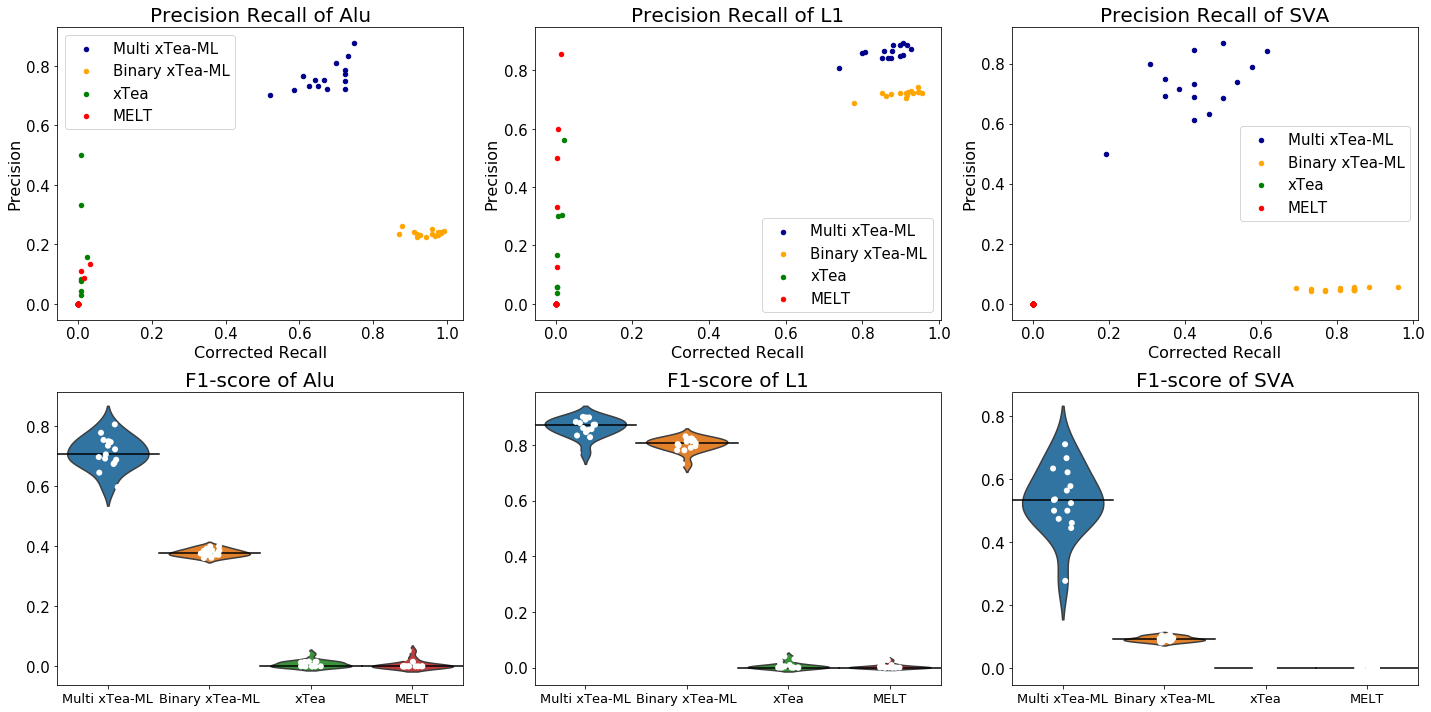

In [31]:
fig, axes = plt.subplots(2, len(RT_list), figsize=(20, 10))
for i in range(len(RT_list)):
    if RT_list[i] == "Alu":
        multi_Alu_high.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi xTea-ML", ax=axes[0,i])
        Alu_highcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Orange", label="Binary xTea-ML", ax=axes[0,i])
        xTea_high.plot.scatter(y="Alu_pre", x="Alu_sen", c="Green", label="xTea", ax=axes[0,i])
        MELT_high.plot.scatter(y="Alu_pre", x="Alu_sen", c="Red", label="MELT", ax=axes[0,i])
        axes[0,i].legend(prop={'size':15})
        axes[0,i].tick_params(axis='x', labelsize=15)
        axes[0,i].tick_params(axis='y', labelsize=15)
        multi_median = np.median(multi_Alu_high["Corr F1-score"])
        bi_median = np.median(Alu_highcov_df["Corr F1-score"])
        xTea_median = np.median(xTea_high["Alu_F1"])
        melt_median = np.median(MELT_high["Alu_F1"])
        _, p_val = wilcoxon(multi_Alu_high["Corr F1-score"], Alu_highcov_df["Corr F1-score"])
        print("Alu")
        print(f"multi: {multi_median}, binary: {bi_median}, xTea:{xTea_median}, MELT:{melt_median}, "
              f"wilcoxon test p-value: {p_val}, avg latency:7.9 ms")
        axes[1, i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.25)
        axes[1, i].axhline(y = bi_median, color="black", xmin = 0.25, xmax = 0.5)
        axes[1, i].axhline(y = xTea_median, color="black", xmin = 0.5, xmax = 0.75)
        axes[1, i].axhline(y = melt_median, color="black", xmin = 0.75, xmax = 1)
        axes[1,i].tick_params(axis='x', labelsize=13)
        axes[1,i].tick_params(axis='y', labelsize=15)
        new = pd.DataFrame({"Multi xTea-ML":list(multi_Alu_high["Corr F1-score"]), "Binary xTea-ML":list(Alu_highcov_df["Corr F1-score"]),
                           "xTea":list(xTea_high["Alu_F1"]), "MELT":list(MELT_high["Alu_F1"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    elif RT_list[i] == "L1":
        multi_L1_high.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi xTea-ML", ax=axes[0,i])
        L1_highcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Orange", label="Binary xTea-ML", ax=axes[0,i])
        xTea_high.plot.scatter(y="L1_pre", x="L1_sen", c="Green", label="xTea", ax=axes[0,i])
        MELT_high.plot.scatter(y="L1_pre", x="L1_sen", c="Red", label="MELT", ax=axes[0,i])
        axes[0,i].legend(prop={'size':15})
        axes[0,i].tick_params(axis='x', labelsize=15)
        axes[0,i].tick_params(axis='y', labelsize=15)
        multi_median = np.median(multi_L1_high["Corr F1-score"])
        bi_median = np.median(L1_highcov_df["Corr F1-score"])
        xTea_median = np.median(xTea_high["L1_F1"])
        melt_median = np.median(MELT_high["L1_F1"])
        _, p_val = wilcoxon(multi_L1_high["Corr F1-score"], L1_highcov_df["Corr F1-score"])
        print("L1")
        print(f"multi: {multi_median}, binary: {bi_median}, xTea:{xTea_median}, MELT:{melt_median}, "
              f"wilcoxon test p-value: {p_val}, avg latency:54.5 ms")
        axes[1, i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.25)
        axes[1, i].axhline(y = bi_median, color="black", xmin = 0.25, xmax = 0.5)
        axes[1, i].axhline(y = xTea_median, color="black", xmin = 0.5, xmax = 0.75)
        axes[1, i].axhline(y = melt_median, color="black", xmin = 0.75, xmax = 1)
        axes[1,i].tick_params(axis='x', labelsize=13)
        axes[1,i].tick_params(axis='y', labelsize=15)
        new = pd.DataFrame({"Multi xTea-ML":list(multi_L1_high["Corr F1-score"]), "Binary xTea-ML":list(L1_highcov_df["Corr F1-score"]),
                           "xTea":list(xTea_high["L1_F1"]), "MELT":list(MELT_high["L1_F1"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    else:
        multi_SVA_high.plot.scatter(y="Precision", x="Corr Recall", c="DarkBlue", label="Multi xTea-ML", ax=axes[0,i])
        SVA_highcov_df.plot.scatter(y="Precision", x="Corr Recall", c="Orange", label="Binary xTea-ML", ax=axes[0,i])
        xTea_high.plot.scatter(y="SVA_pre", x="SVA_sen", c="Green", label="xTea", ax=axes[0,i])
        MELT_high.plot.scatter(y="SVA_pre", x="SVA_sen", c="Red", label="MELT", ax=axes[0,i])
        axes[0,i].legend(prop={'size':15})
        axes[0,i].tick_params(axis='x', labelsize=15)
        axes[0,i].tick_params(axis='y', labelsize=15)
        multi_median = np.median(multi_SVA_high["Corr F1-score"])
        bi_median = np.median(SVA_highcov_df["Corr F1-score"])
        xTea_median = np.median(xTea_high["SVA_F1"])
        melt_median = np.median(MELT_high["SVA_F1"])
        _, p_val = wilcoxon(multi_SVA_high["Corr F1-score"], SVA_highcov_df["Corr F1-score"])
        print("SVA")
        print(f"multi: {multi_median}, binary: {bi_median}, xTea:{xTea_median}, MELT:{melt_median}, "
              f"wilcoxon test p-value: {p_val}, avg latency:3.73 ms")
        axes[1, i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.25)
        axes[1, i].axhline(y = bi_median, color="black", xmin = 0.25, xmax = 0.5)
        axes[1, i].axhline(y = xTea_median, color="black", xmin = 0.5, xmax = 0.75)
        axes[1, i].axhline(y = melt_median, color="black", xmin = 0.75, xmax = 1)
        axes[1,i].tick_params(axis='x', labelsize=13)
        axes[1,i].tick_params(axis='y', labelsize=15)
        new = pd.DataFrame({"Multi xTea-ML":list(multi_SVA_high["Corr F1-score"]), "Binary xTea-ML":list(SVA_highcov_df["Corr F1-score"]),
                           "xTea":list(xTea_high["SVA_F1"]), "MELT":list(MELT_high["SVA_F1"])})
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[1, i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[1, i])
    
    axes[0, i].set_title(f"Precision Recall of {RT_list[i]}", fontsize = 20)
    axes[0, i].set_xlabel("Corrected Recall", fontsize=16)
    axes[0, i].set_ylabel("Precision", fontsize=16)
    axes[1, i].set_title(f"F1-score of {RT_list[i]}", fontsize=20)
    
plt.tight_layout()
plt.savefig("./stats/highcov_performance_comparison.png")

Alu
multi: 0.54, binary: 0.625, wilcoxon test p-value: 0.005062032126267864
L1
multi: 0.6159999999999999, binary: 0.616, wilcoxon test p-value: 0.4445867389117455
SVA
multi: 0.494, binary: 0.5145, wilcoxon test p-value: 0.6464622026641696


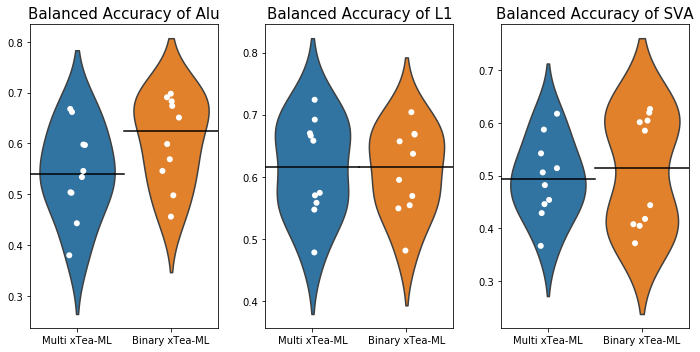

In [32]:
fig, axes = plt.subplots(1, len(RT_list), figsize=(10, 5))
for i in range(len(RT_list)):
    if RT_list[i] == "Alu":
        new = pd.DataFrame({"Multi xTea-ML":list(multi_Alu_low["Corr Balanced Accu"]), "Binary xTea-ML":list(Alu_lowcov_df["Corr Balanced Acc"])})
        multi_median = np.median(multi_Alu_low["Corr Balanced Accu"])
        bi_median = np.median(Alu_lowcov_df["Corr Balanced Acc"])
        _, p_val = wilcoxon(multi_Alu_low["Corr Balanced Accu"], Alu_lowcov_df["Corr Balanced Acc"])
        print("Alu")
        print(f"multi: {multi_median}, binary: {bi_median}, wilcoxon test p-value: {p_val}")
        axes[i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.5)
        axes[i].axhline(y = bi_median, color="black", xmin = 0.5, xmax = 1)
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[i])
    elif RT_list[i] == "L1":
        new = pd.DataFrame({"Multi xTea-ML":list(multi_L1_low["Corr Balanced Accu"]), "Binary xTea-ML":list(L1_lowcov_df["Corr Balanced Acc"])})
        multi_median = np.median(multi_L1_low["Corr Balanced Accu"])
        bi_median = np.median(L1_lowcov_df["Corr Balanced Acc"])
        _, p_val = wilcoxon(multi_L1_low["Corr Balanced Accu"], L1_lowcov_df["Corr Balanced Acc"])
        print("L1")
        print(f"multi: {multi_median}, binary: {bi_median}, wilcoxon test p-value: {p_val}")
        axes[i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.5)
        axes[i].axhline(y = bi_median, color="black", xmin = 0.5, xmax = 1)
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[i])
    else:
        new = pd.DataFrame({"Multi xTea-ML":list(multi_SVA_low["Corr Balanced Accu"]), "Binary xTea-ML":list(SVA_lowcov_df["Corr Balanced Acc"])})
        multi_median = np.median(multi_SVA_low["Corr Balanced Accu"])
        bi_median = np.median(SVA_lowcov_df["Corr Balanced Acc"])
        _, p_val = wilcoxon(multi_SVA_low["Corr Balanced Accu"], SVA_lowcov_df["Corr Balanced Acc"])
        print("SVA")
        print(f"multi: {multi_median}, binary: {bi_median}, wilcoxon test p-value: {p_val}")
        axes[i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.5)
        axes[i].axhline(y = bi_median, color="black", xmin = 0.5, xmax = 1)
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[i])
    axes[i].set_title(f"Balanced Accuracy of {RT_list[i]}", fontsize=15)
    
plt.tight_layout()
plt.savefig("./stats/lowcov_Multi_vs_Binary_Bal_Accu.png")

Alu
multi: 0.8140000000000001, binary: 0.768, wilcoxon test p-value: 0.0014665230830596743
L1
multi: 0.902, binary: 0.836, wilcoxon test p-value: 0.0006533107814151376
SVA
multi: 0.6940000000000001, binary: 0.703, wilcoxon test p-value: 0.7763811150102832


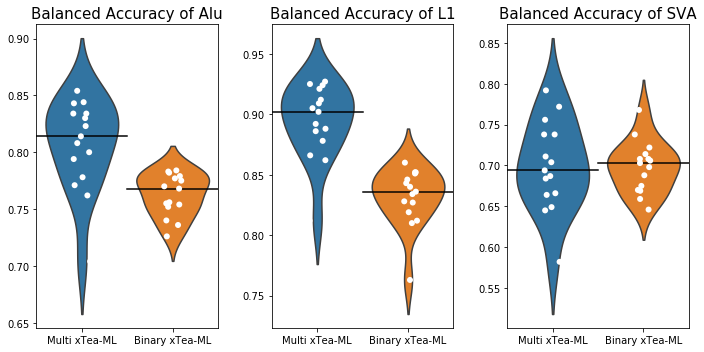

In [33]:
fig, axes = plt.subplots(1, len(RT_list), figsize=(10, 5))
for i in range(len(RT_list)):
    if RT_list[i] == "Alu":
        new = pd.DataFrame({"Multi xTea-ML":list(multi_Alu_high["Corr Balanced Accu"]), "Binary xTea-ML":list(Alu_highcov_df["Corr Balanced Acc"])})
        multi_median = np.median(multi_Alu_high["Corr Balanced Accu"])
        bi_median = np.median(Alu_highcov_df["Corr Balanced Acc"])
        _, p_val = wilcoxon(multi_Alu_high["Corr Balanced Accu"], Alu_highcov_df["Corr Balanced Acc"])
        print("Alu")
        print(f"multi: {multi_median}, binary: {bi_median}, wilcoxon test p-value: {p_val}")
        axes[i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.5)
        axes[i].axhline(y = bi_median, color="black", xmin = 0.5, xmax = 1)
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[i])
    elif RT_list[i] == "L1":
        new = pd.DataFrame({"Multi xTea-ML":list(multi_L1_high["Corr Balanced Accu"]), "Binary xTea-ML":list(L1_highcov_df["Corr Balanced Acc"])})
        multi_median = np.median(multi_L1_high["Corr Balanced Accu"])
        bi_median = np.median(L1_highcov_df["Corr Balanced Acc"])
        _, p_val = wilcoxon(multi_L1_high["Corr Balanced Accu"], L1_highcov_df["Corr Balanced Acc"])
        print("L1")
        print(f"multi: {multi_median}, binary: {bi_median}, wilcoxon test p-value: {p_val}")
        axes[i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.5)
        axes[i].axhline(y = bi_median, color="black", xmin = 0.5, xmax = 1)
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[i])
    else:
        new = pd.DataFrame({"Multi xTea-ML":list(multi_SVA_high["Corr Balanced Accu"]), "Binary xTea-ML":list(SVA_highcov_df["Corr Balanced Acc"])})
        multi_median = np.median(multi_SVA_high["Corr Balanced Accu"])
        bi_median = np.median(SVA_highcov_df["Corr Balanced Acc"])
        _, p_val = wilcoxon(multi_SVA_high["Corr Balanced Accu"], SVA_highcov_df["Corr Balanced Acc"])
        print("SVA")
        print(f"multi: {multi_median}, binary: {bi_median}, wilcoxon test p-value: {p_val}")
        axes[i].axhline(y = multi_median, color="black", xmin = 0, xmax = 0.5)
        axes[i].axhline(y = bi_median, color="black", xmin = 0.5, xmax = 1)
        sns.violinplot(data=new, scale="count", inner=None, ax=axes[i])
        sns.stripplot(data=new, color='white', size=6, edgecolor='gray', ax=axes[i])
    
    axes[i].set_title(f"Balanced Accuracy of {RT_list[i]}", fontsize=15)
    
plt.tight_layout()
plt.savefig("./stats/highcov_Multi_vs_Binary_Bal_Accu.png")

In [39]:
multi_Alu_high.describe()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
count,15.000000,15.000000,15.000000,15.000000
mean,0.806200,0.762333,0.670000,0.712333
std,0.039773,0.047491,0.064869,0.053331
min,0.704000,0.703000,0.520000,0.598000
25%,0.786000,0.728500,0.634000,0.684000
50%,0.814000,0.752000,0.675000,0.707000
75%,0.834000,0.781000,0.724000,0.749500
max,0.854000,0.876000,0.748000,0.807000


In [40]:
multi_L1_high.describe()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
count,15.000000,15.000000,15.000000,15.000000
mean,0.893933,0.861067,0.866733,0.863333
std,0.030828,0.023230,0.050383,0.034259
min,0.812000,0.807000,0.740000,0.772000
25%,0.882000,0.846000,0.854000,0.850000
50%,0.902000,0.862000,0.878000,0.873000
75%,0.916500,0.880000,0.901500,0.887000
max,0.927000,0.893000,0.926000,0.901000


In [41]:
multi_SVA_high.describe()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
count,15.000000,15.000000,15.000000,15.000000
mean,0.698800,0.725667,0.430733,0.535133
std,0.054935,0.098406,0.108948,0.105185
min,0.582000,0.500000,0.192000,0.277000
25%,0.665000,0.686000,0.365500,0.487000
50%,0.694000,0.733000,0.423000,0.534000
75%,0.738000,0.794500,0.500000,0.600000
max,0.792000,0.867000,0.615000,0.711000


In [34]:
Alu_highcov_df.describe()

,Corr Balanced Acc,Precision,Corr Recall,Corr F1-score
count,15.000000,15.000000,15.000000,15.000000
mean,0.762467,0.237733,0.944267,0.379533
std,0.018535,0.009625,0.038721,0.012328
min,0.726000,0.224000,0.870000,0.361000
25%,0.753000,0.233000,0.919000,0.371000
50%,0.768000,0.235000,0.959000,0.377000
75%,0.778000,0.241000,0.976000,0.387000
max,0.784000,0.260000,0.992000,0.401000


In [35]:
L1_highcov_df.describe()

,Corr Balanced Acc,Precision,Corr Recall,Corr F1-score
count,15.000000,15.000000,15.000000,15.000000
mean,0.831533,0.720400,0.904800,0.801933
std,0.024198,0.011581,0.046752,0.024714
min,0.763000,0.690000,0.779000,0.732000
25%,0.823000,0.717500,0.885500,0.793000
50%,0.836000,0.722000,0.915000,0.806000
75%,0.848500,0.726500,0.938000,0.819000
max,0.860000,0.742000,0.954000,0.831000


In [36]:
SVA_highcov_df.describe()

,Corr Balanced Acc,Precision,Corr Recall,Corr F1-score
count,15.000000,15.000000,15.000000,15.000000
mean,0.698133,0.049067,0.815400,0.092467
std,0.031735,0.004367,0.068579,0.008088
min,0.646000,0.043000,0.692000,0.081000
25%,0.672500,0.046000,0.769000,0.087000
50%,0.703000,0.049000,0.846000,0.092000
75%,0.711000,0.052500,0.846000,0.098000
max,0.768000,0.056000,0.962000,0.105000


In [37]:
Alu_lowcov_df.describe()

,Corr Balanced Acc,Precision,Corr Recall,Corr F1-score
count,10.000000,10.000000,10.000000,10.00000
mean,0.606500,0.242800,0.663300,0.35370
std,0.086568,0.023475,0.147535,0.04606
min,0.456000,0.195000,0.407000,0.27400
25%,0.551750,0.230250,0.579000,0.33000
50%,0.625000,0.243000,0.707500,0.36350
75%,0.680750,0.255750,0.780000,0.38400
max,0.698000,0.279000,0.813000,0.41500


In [38]:
L1_lowcov_df.describe()

,Corr Balanced Acc,Precision,Corr Recall,Corr F1-score
count,10.000000,10.000000,10.00000,10.000000
mean,0.608300,0.562400,0.57340,0.564900
std,0.069916,0.052235,0.12050,0.086408
min,0.481000,0.474000,0.31700,0.380000
25%,0.557750,0.532250,0.51275,0.515750
50%,0.616000,0.573000,0.58200,0.576500
75%,0.665250,0.593750,0.65800,0.628750
max,0.704000,0.626000,0.73800,0.677000


In [39]:
SVA_lowcov_df.describe()

,Corr Balanced Acc,Precision,Corr Recall,Corr F1-score
count,10.000000,10.00000,10.000000,10.000000
mean,0.508200,0.04260,0.457600,0.077700
std,0.106113,0.01266,0.177168,0.023697
min,0.372000,0.02500,0.269000,0.046000
25%,0.410500,0.03100,0.278750,0.055500
50%,0.514500,0.04300,0.461500,0.078500
75%,0.603250,0.05250,0.615000,0.097000
max,0.626000,0.06200,0.654000,0.113000


In [40]:
multi_Alu_low.describe()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
count,10.000000,10.000000,10.000000,10.000000
mean,0.543500,0.479900,0.317800,0.380300
std,0.091594,0.133631,0.122493,0.130571
min,0.380000,0.263000,0.122000,0.167000
25%,0.503250,0.427500,0.264000,0.333000
50%,0.540000,0.479000,0.313000,0.368500
75%,0.597750,0.579000,0.390000,0.465750
max,0.668000,0.659000,0.488000,0.556000


In [43]:
multi_L1_low.describe()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
count,10.00000,10.000000,10.000000,10.000000
mean,0.61370,0.577200,0.526000,0.548400
std,0.07861,0.067643,0.118197,0.096994
min,0.47800,0.462000,0.290000,0.356000
25%,0.56100,0.526750,0.458250,0.491500
50%,0.61600,0.580000,0.540000,0.558500
75%,0.66900,0.635000,0.595000,0.616000
max,0.72400,0.665000,0.694000,0.679000


In [44]:
multi_SVA_low.describe()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
count,10.000000,10.000000,10.000000,10.000000
mean,0.494400,0.417900,0.188400,0.255600
std,0.075297,0.182829,0.089778,0.112821
min,0.367000,0.167000,0.077000,0.108000
25%,0.448000,0.314250,0.115000,0.168500
50%,0.494000,0.369500,0.173000,0.233000
75%,0.535000,0.560500,0.231000,0.343000
max,0.617000,0.667000,0.346000,0.418000
